In [1]:
import pandas as pd

from country_abbrev import *
from country_language import *
from pytrends.request import TrendReq

import trends_helpers
import os
import pycountry

In [2]:
os.getcwd()

"g:\\Mi unidad\\BSE - DSDM\\Master's project\\refugees\\notebooks\\trends"

In [3]:
currencies = pd.read_excel("countries-codes-and-currencies-(2020).xlsx")

In [4]:
currencies.head()

,Country Code,Country Name,WHO Region,World Bank Income Group (2018),Currency Name,Currency Code
0,AFG,Afghanistan,EMR,Low,Afghanistan Afghani,AFN
1,ALB,Albania,EUR,Upper‐middle,Albanian Lek,ALL
2,DZA,Algeria,AFR,Upper‐middle,Algerian Dinar,DZD
3,AND,Andorra,EUR,High,Euro,EUR
4,AGO,Angola,AFR,Lower‐middle,Angolan Kwanza,AON


In [5]:
currencies.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Country Code                    194 non-null    object
 1   Country Name                    194 non-null    object
 2   WHO Region                      194 non-null    object
 3   World Bank Income Group (2018)  194 non-null    object
 4   Currency Name                   194 non-null    object
 5   Currency Code                   194 non-null    object
dtypes: object(6)
memory usage: 9.2+ KB


In [6]:
keywords_list= list(set(currencies["Currency Name"]))
len(keywords_list)

# First search as it comes, then we can translate for each origin lang

141

In [7]:
countries_iso3 = currencies["Country Code"]
countries = [pycountry.countries.get(alpha_3=code).alpha_2 for code in countries_iso3]

In [62]:
countries = ["SY"]
keywords_list = ["Turkey", "Germany"]

In [75]:
from pytrends.request import TrendReq
import time


# Set up the Google Trends API object
# pytrends = TrendReq()
# I'll define the object within the loop

# Initialize an empty DataFrame to store the results
results = pd.DataFrame()


# Loop through regions and keywords
for keyword in keywords_list:
    for i, country in enumerate(countries):    
        # pytrends = TrendReq(timeout=(10,25), proxies=proxy_list, retries=2, backoff_factor=0.1,    )

        pytrends = TrendReq(tz=360, timeout=(10, 25), retries=2, backoff_factor=0.5, 
                            requests_args={'headers': {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36 Edge/16.16299'}})
        
# The timeout parameter sets the maximum number of seconds to wait for a response from the API 
# before raising a timeout error.
#The backoff_factor parameter is used for exponential backoff when retrying requests. 
# It specifies the factor by which the waiting time between retries increases on each retry. 
# For example, if backoff_factor is set to 0.4, the waiting time between retries will increase by 40% on
# each retry.
# The retries parameter sets the maximum number of times to retry a request if it fails with a 
# transient error (such as a connection error or server error). If the maximum number of retries 
# is exceeded, an exception will be raised.   
        print("Searching: " + str(keyword) + " in " + str(country))
        time.sleep(4)
        
        # Build the payload with the selected region, keyword and date range
        pytrends.build_payload(kw_list=[keyword], timeframe="all", geo=str(country))
        # Get the interest over time data for the selected keyword
        interest_over_time_df = pytrends.interest_over_time()

        # Check if the DataFrame is not empty
        if not interest_over_time_df.empty:
            interest_over_time_df= interest_over_time_df.reset_index()
            interest_over_time_df['trends_index'] = interest_over_time_df.iloc[:, 1] 
            interest_over_time_df = interest_over_time_df.drop(interest_over_time_df.columns[1], axis=1)

            interest_over_time_df = interest_over_time_df.drop(columns=["isPartial"], axis=1)
            interest_over_time_df["keyword"]=keyword
            interest_over_time_df["region"] = country
            
            # Append the results to the main dataframe
            results = pd.concat([results, interest_over_time_df])



Searching: Turkey in SY
Searching: Germany in SY


In [73]:
results_08 = results.copy()

In [76]:
results_08 = results_08.rename(columns={"trends_index":"trends_index_08"})

In [78]:
results_merged = pd.merge(results, results_08, on=["date", "keyword", "region"], how="left")

<Axes: >

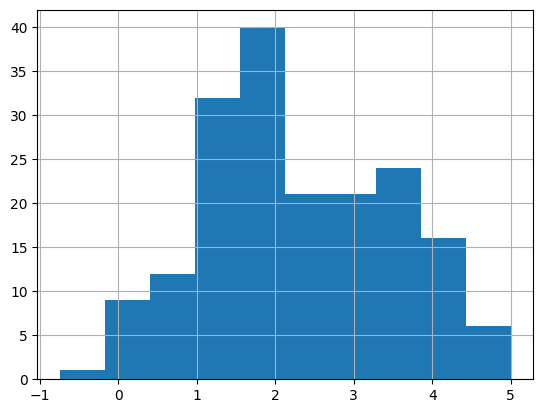

In [81]:
results_merged['date'] = pd.to_datetime(results_merged['date'])
ph = results_merged[results_merged["keyword"]=="Turkey"]

ph = ph[ph['date'] > '2008-01-01']

min_value = ph['trends_index'].min()
max_value = ph['trends_index'].max()

# Normalize 'x' between 0 and 100
ph['normalized_ti'] = (ph['trends_index'] - min_value) * 100 / (max_value - min_value)
ph["difference"] = ph["trends_index_08"] - ph["normalized_ti"]
ph["difference"].hist()

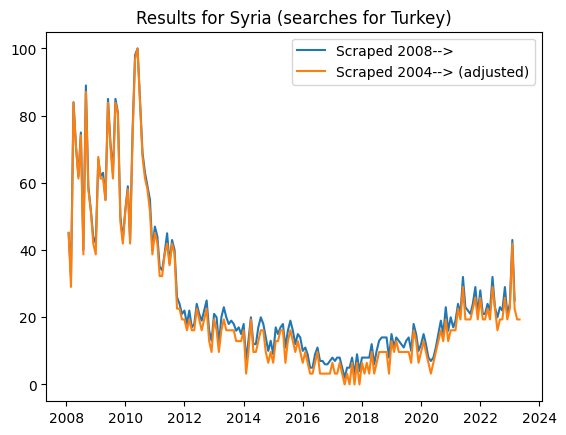

In [84]:
plt.plot(ph["date"], ph["trends_index_08"], label='Scraped 2008-->')
plt.plot(ph["date"], ph["normalized_ti"], label='Scraped 2004--> (adjusted)')

# Show legend
plt.legend()
plt.title('Results for Syria (searches for Turkey)')
# Display the plot
plt.show()

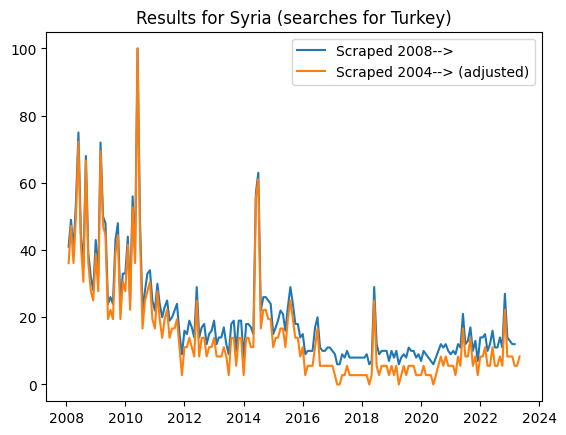

In [85]:
ph = results_merged[results_merged["keyword"]=="Germany"]

ph = ph[ph['date'] > '2008-01-01']

min_value = ph['trends_index'].min()
max_value = ph['trends_index'].max()

# Normalize 'x' between 0 and 100
ph['normalized_ti'] = (ph['trends_index'] - min_value) * 100 / (max_value - min_value)
ph["difference"] = ph["trends_index_08"] - ph["normalized_ti"]

plt.plot(ph["date"], ph["trends_index_08"], label='Scraped 2008-->')
plt.plot(ph["date"], ph["normalized_ti"], label='Scraped 2004--> (adjusted)')

# Show legend
plt.legend()
plt.title('Results for Syria (searches for Turkey)')
# Display the plot
plt.show()

In [16]:
results.to_csv("C:/Users/danid/Documents/currency_short.csv") # CHANGE

Merge datasets

In [9]:
import glob
import pandas as pd

# Directory containing CSV files
directory = 'currency_partial results/*.csv'

# Get a list of all CSV files in the directory
file_list = glob.glob(directory)

# Initialize an empty list to store DataFrames
dfs = []

# Read and concatenate each CSV file
for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [10]:
combined_df = combined_df.drop_duplicates()
combined_df =  combined_df.drop(columns=["Unnamed: 0"])

In [5]:
combined_df

,date,trends_index,keyword,region
0,2004-01-01,0,New Manat,AU
1,2004-02-01,0,New Manat,AU
2,2004-03-01,0,New Manat,AU
3,2004-04-01,0,New Manat,AU
4,2004-05-01,50,New Manat,AU
...,...,...,...,...
1734680,2023-01-01,1,Kuna,ZW
1734681,2023-02-01,1,Kuna,ZW
1734682,2023-03-01,0,Kuna,ZW
1734683,2023-04-01,0,Kuna,ZW


In [12]:
combined_df.to_csv("currency_partial results/Searches in English_complete.csv", index=False)

In [13]:
combined_df = pd.read_csv("currency_partial results/Searches in English_complete.csv")

In [14]:
combined_df

,date,trends_index,keyword,region
0,2004-01-01,0,New Manat,AU
1,2004-02-01,0,New Manat,AU
2,2004-03-01,0,New Manat,AU
3,2004-04-01,0,New Manat,AU
4,2004-05-01,50,New Manat,AU
...,...,...,...,...
2986206,2023-01-01,1,Kuna,ZW
2986207,2023-02-01,1,Kuna,ZW
2986208,2023-03-01,0,Kuna,ZW
2986209,2023-04-01,0,Kuna,ZW


In [44]:
short_results = pd.read_csv("C:/Users/danid/Documents/currency_short.csv") 

In [45]:
short_results = short_results.drop(columns=["Unnamed: 0"])

In [46]:
short_results = short_results.rename(columns={"trends_index": "trends_index_08"})

In [47]:
merged = pd.merge(combined_df, short_results, on=["date", "keyword", "region"], how="left")

In [48]:
merged_ok = merged.dropna()

In [49]:
merged_ok['date'] = pd.to_datetime(merged_ok['date'])
merged_ok

C:\Users\danid\AppData\Local\Temp\ipykernel_8404\701770334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_ok['date'] = pd.to_datetime(merged_ok['date'])


,date,trends_index,keyword,region,trends_index_08
208122,2008-01-01,0,Nepalese Rupee,AU,0.0
208123,2008-02-01,24,Nepalese Rupee,AU,0.0
208124,2008-03-01,0,Nepalese Rupee,AU,0.0
208125,2008-04-01,0,Nepalese Rupee,AU,33.0
208126,2008-05-01,0,Nepalese Rupee,AU,0.0
...,...,...,...,...,...
220416,2022-11-01,0,Bhat,MV,4.0
220417,2022-12-01,0,Bhat,MV,0.0
220418,2023-01-01,0,Bhat,MV,7.0
220419,2023-02-01,0,Bhat,MV,7.0


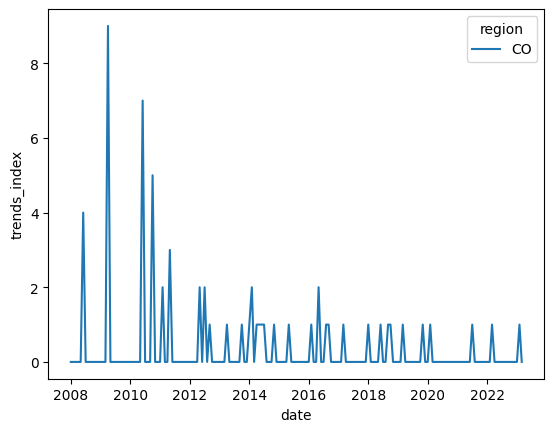

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

col = merged_ok[merged_ok["region"]=="CO"]

sns.lineplot(data=col, x='date', y='trends_index', hue='region')
plt.show()

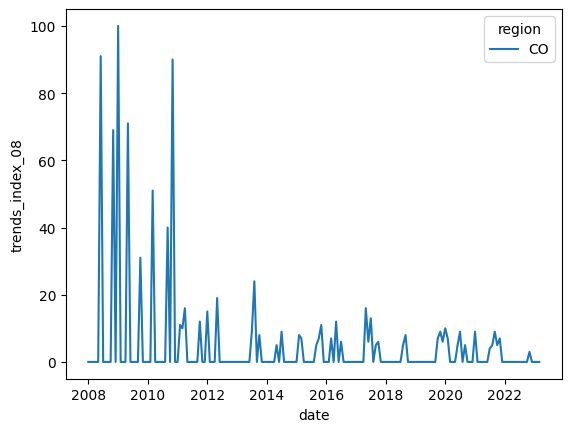

In [51]:
sns.lineplot(data=col, x='date', y='trends_index_08', hue='region')
plt.show()

Let's normalize between 0 and 100 the values scraped since 2004, but considering the max obtained in the period 2008-2023

In [52]:
min_value = col['trends_index'].min()
max_value = col['trends_index'].max()

# Normalize 'x' between 0 and 100
col['normalized_ti'] = (col['trends_index'] - min_value) * 100 / (max_value - min_value)


C:\Users\danid\AppData\Local\Temp\ipykernel_8404\3036695164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col['normalized_ti'] = (col['trends_index'] - min_value) * 100 / (max_value - min_value)


C:\Users\danid\AppData\Local\Temp\ipykernel_8404\3635028446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col["difference"] = col["trends_index_08"] - col["normalized_ti"]


<Axes: >

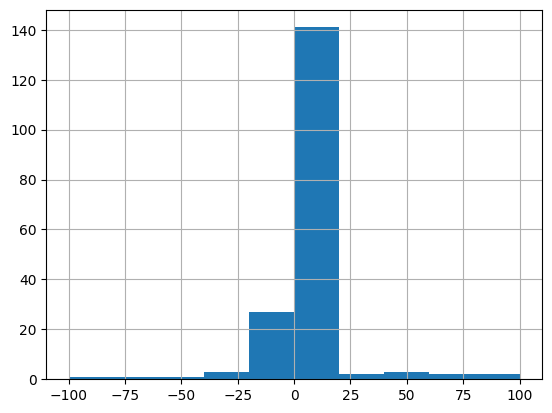

In [53]:
col["difference"] = col["trends_index_08"] - col["normalized_ti"]
col["difference"].hist()

In [54]:
col["difference"].mean()

1.170006071645416

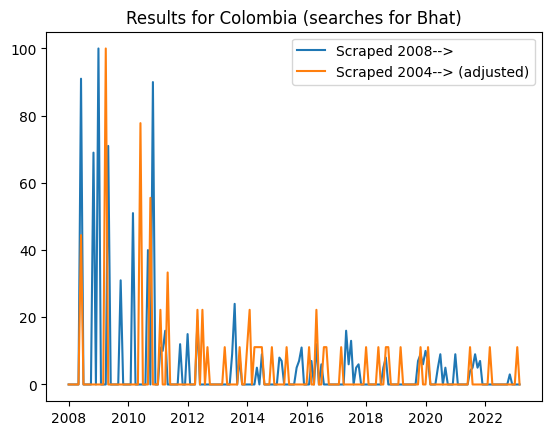

In [56]:
plt.plot(col["date"], col["trends_index_08"], label='Scraped 2008-->')
plt.plot(col["date"], col["normalized_ti"], label='Scraped 2004--> (adjusted)')

# Show legend
plt.legend()
plt.title('Results for Colombia (searches for Bhat)')
# Display the plot
plt.show()

C:\Users\danid\AppData\Local\Temp\ipykernel_8404\233679510.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph['normalized_ti'] = (ph['trends_index'] - min_value) * 100 / (max_value - min_value)
C:\Users\danid\AppData\Local\Temp\ipykernel_8404\233679510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph["difference"] = ph["trends_index_08"] - ph["normalized_ti"]


<Axes: >

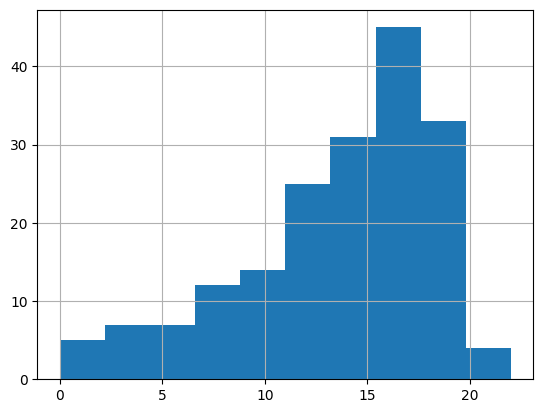

In [60]:
ph = merged_ok[(merged_ok["region"]=="IN") & (merged_ok["keyword"]=="Bhat")]

min_value = ph['trends_index'].min()
max_value = ph['trends_index'].max()

# Normalize 'x' between 0 and 100
ph['normalized_ti'] = (ph['trends_index'] - min_value) * 100 / (max_value - min_value)
ph["difference"] = ph["trends_index_08"] - ph["normalized_ti"]
ph["difference"].hist()


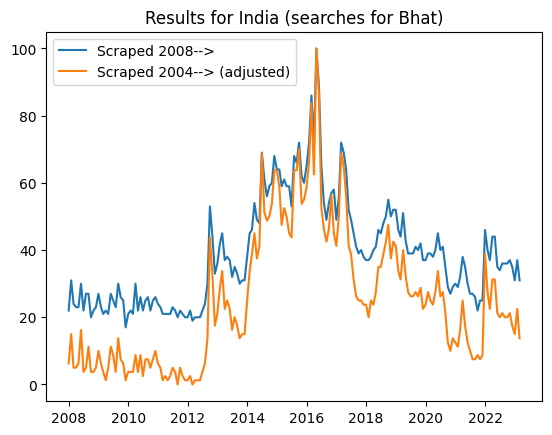

In [61]:
plt.plot(ph["date"], ph["trends_index_08"], label='Scraped 2008-->')
plt.plot(ph["date"], ph["normalized_ti"], label='Scraped 2004--> (adjusted)')

# Show legend
plt.legend()
plt.title('Results for India (searches for Bhat)')
# Display the plot
plt.show()